In [22]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, cross_validation, feature_selection, metrics, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis
from xgboost import XGBClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
 def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)

base_color = 'lightskyblue'
base_color2 = 'gray'
cm = generate_cmap([base_color2, 'white', base_color])

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

len(df_train), len(df_test)

(891, 418)

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
# データ型

print('train '+'-'*50)
print(df_train.dtypes)
print('test '+'-'*50)
print(df_test.dtypes)

train --------------------------------------------------
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
test --------------------------------------------------
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [8]:
# 欠損値

print('train '+'-'*50)
print(df_train.isnull().sum())
print('test '+'-'*50)
print(df_test.isnull().sum())

train --------------------------------------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
test --------------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [9]:
# 教師データで全体の生存率を確認

df_train['Survived'].sum()/df_train['Survived'].count()

0.3838383838383838

In [10]:
# 調査、加工用に一度連結する

train_tmp = df_train.copy()
test_tmp = df_test.copy()
train_tmp = train_tmp.drop("Survived", axis=1)
df = pd.concat([train_tmp, test_tmp])
len(df)

1309

In [11]:
# 性別をラベル化

label_encoder_sex = preprocessing.LabelEncoder()
df['Sex_l'] = label_encoder_sex.fit_transform(df['Sex'])
df[['Sex', 'Sex_l']].head()

,Sex,Sex_l
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


In [12]:
# 生存と他の変数の相関係数の確認

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.dropna() # 欠損データ削除
df_tmp.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_l
PassengerId,1.000000,0.148495,-0.089136,0.030933,-0.083488,-0.051454,0.029740,-0.025205
Survived,0.148495,1.000000,-0.034542,-0.254085,0.106346,0.023582,0.134241,-0.532418
Pclass,-0.089136,-0.034542,1.000000,-0.306514,-0.103592,0.047496,-0.315235,-0.046181
Age,0.030933,-0.254085,-0.306514,1.000000,-0.156162,-0.271271,-0.092424,0.184969
SibSp,-0.083488,0.106346,-0.103592,-0.156162,1.000000,0.255346,0.286433,-0.104291
Parch,-0.051454,0.023582,0.047496,-0.271271,0.255346,1.000000,0.389740,-0.089581
Fare,0.029740,0.134241,-0.315235,-0.092424,0.286433,0.389740,1.000000,-0.130433
Sex_l,-0.025205,-0.532418,-0.046181,0.184969,-0.104291,-0.089581,-0.130433,1.000000


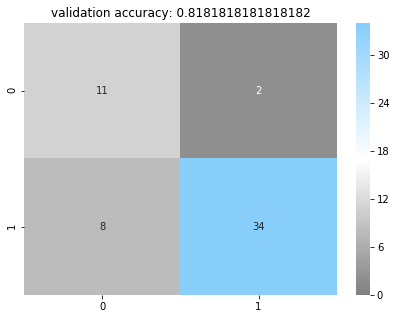

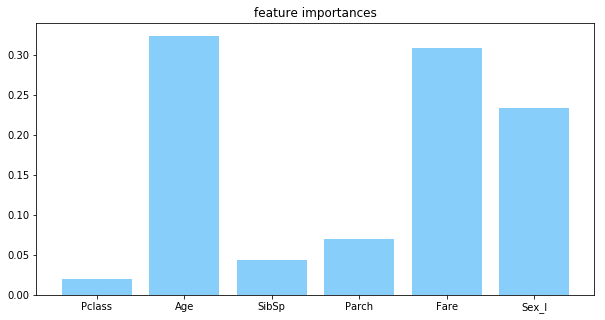

In [13]:
# まずは欠損していないデータのみでベースラインモデルを作成

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.dropna()
cols = df_tmp.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols.remove('PassengerId')
cols.remove('Survived')

# ランダムフォレスト
train_x, valid_x, train_y, valid_y = cross_validation.train_test_split(df_tmp[cols], df_tmp['Survived'], test_size=0.3, random_state=0)
model = ensemble.RandomForestClassifier()
model.fit(train_x, train_y)
pred = model.predict(valid_x)
plt.figure(figsize=(7,5))
sns.heatmap(metrics.confusion_matrix(valid_y, pred), vmin=0, annot=True, fmt='d', cmap=cm)
plt.title('validation accuracy: {}'.format(metrics.accuracy_score(valid_y, pred)))
plt.show()

# 変数重要度プロット
left = list(range(1, len(cols)+1))
height = model.feature_importances_
plt.figure(figsize=(10,5))
plt.bar(left, height, tick_label=cols, color=base_color)
plt.title('feature importances')
plt.show()

* 特徴量エンジニアリングを行う

In [14]:
# Fareで欠損しているデータ

df[df[["Fare"]].isnull().any(axis=1)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_l
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1


In [32]:
# Fareと相関が強い変数

df[['Fare', 'Parch', 'Pclass', 'SibSp']].corr() # Pclass=客室クラス、Parch=親または子供の数、SibSp=兄弟の数

,Fare,Parch,Pclass,SibSp
Fare,1.000000,0.221539,-0.558629,0.160238
Parch,0.221539,1.000000,0.018322,0.373587
Pclass,-0.558629,0.018322,1.000000,0.060832
SibSp,0.160238,0.373587,0.060832,1.000000


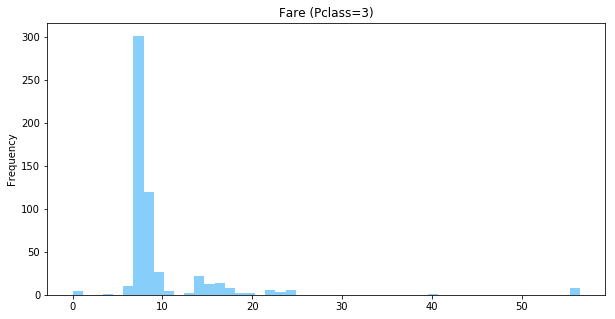

In [35]:
# 乗船料に関係がありそうな客室クラスPclass=3のFareの分布を確認する

df_tmp = df[(df['Pclass'] == 3) & (df['Parch'] == 0)]
df_tmp['Fare'].plot(kind='hist', bins=50, color=base_color, figsize=(10,5))
plt.title('Fare (Pclass=3)')
plt.show()

In [36]:
# Fareの欠損をPclass=3の中央値で補填する

tmp = df.groupby('Pclass')['Fare'].median().reset_index() # 乗船クラスごとのFareの中央値
tmp = tmp.rename(columns={'Fare': 'Fare_median'})
print(tmp[tmp['Pclass'] == 3])

df = pd.merge(df, tmp, how='left', on='Pclass') # Pclass別の中央値をマージ
df['Fare2'] = df['Fare'].fillna(df['Fare_median']) # 欠損値にPclass別Fare中央値を補填
df = df.drop(['Fare_median'], axis=1)
df[df['PassengerId'].isin([1042, 1043, 1044, 1045, 1046])][['Fare', 'Fare2']] # check

   Pclass  Fare_median
2       3         8.05


,Fare,Fare2
1041,83.1583,83.1583
1042,7.8958,7.8958
1043,NaN,8.0500
1044,12.1833,12.1833
1045,31.3875,31.3875


In [37]:
# Ageで欠損しているデータ

df[df[['Age']].isnull().any(axis=1)].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_l,Fare2
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,8.4583
17,18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1,13.0000
19,20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0,7.2250
26,27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,1,7.2250
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0,7.8792


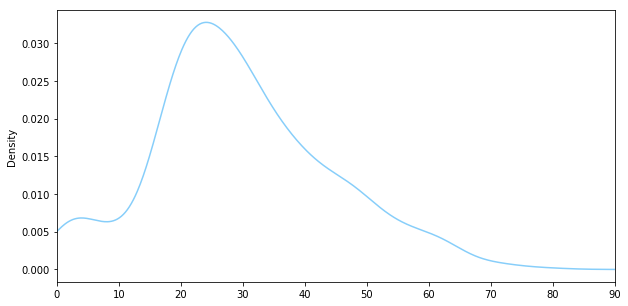

In [38]:
# 全体的な年齢の分布を確認する

df['Age'].plot(kind='kde', color=base_color, figsize=(10, 5))
plt.title('Age')
plt.xlim(0, 90)
plt.show()

In [39]:
# 名前の敬称を年齢補填に利用する。Nameから家族名と敬称を抽出する

def get_family_name(name):
    
    return name.split(',')[0]

def get_name_title(name):
    
    return name.split(',')[1].split('.')[0].lstrip() # 敬称

df['Name_family'] = df['Name'].apply(get_family_name)
df['Name_title'] = df['Name'].apply(get_name_title)

df[['Name', 'Name_family', 'Name_title']].head()

,Name,Name_family,Name_title
0,"Braund, Mr. Owen Harris",Braund,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Mrs
2,"Heikkinen, Miss. Laina",Heikkinen,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Mrs
4,"Allen, Mr. William Henry",Allen,Mr


In [40]:
# 敬称ごとの年齢の欠損を確認する

df_tmp = df.groupby('Name_title')['PassengerId', 'Age'].count().reset_index() # 敬称ごとの件数と、Ageの欠損データが含まれている敬称の確認
df_tmp = df_tmp.rename(columns={'PassengerId': 'row_cnt', 'Age': 'age_cnt'})
df_tmp['age_null_cnt'] = df_tmp['row_cnt'] - df_tmp['age_cnt']
display(df_tmp)

age_null_titles = df_tmp[df_tmp['age_null_cnt'] > 0]['Name_title'].values
age_null_titles

,Name_title,row_cnt,age_cnt,age_null_cnt
0,Capt,1,1,0
1,Col,4,4,0
2,Don,1,1,0
3,Dona,1,1,0
4,Dr,8,7,1
5,Jonkheer,1,1,0
6,Lady,1,1,0
7,Major,2,2,0
8,Master,61,53,8
9,Miss,260,210,50


array(['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms'], dtype=object)

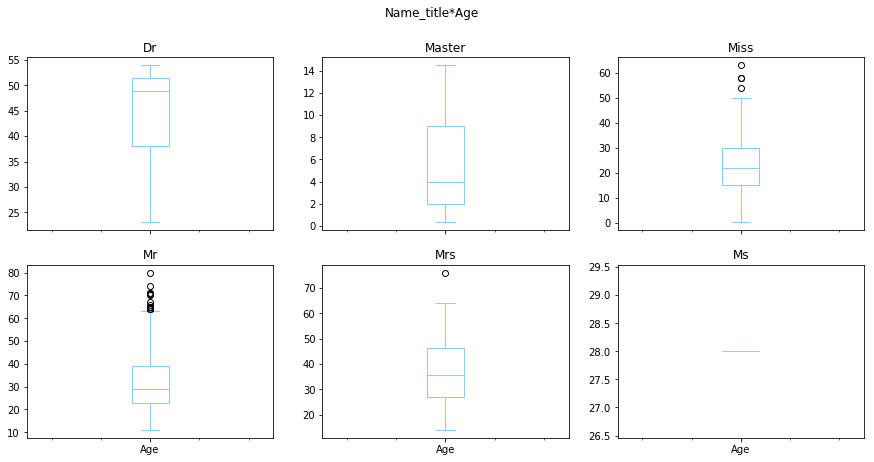

In [87]:
# 年齢に欠損がある敬称別で年齢の分布を確認する

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,7), sharex=True)
axs = axs.flatten()

for i, name_title in enumerate(age_null_titles):
    
    df[df['Name_title'] == name_title]['Age'].plot(kind='box', ax=axs[i], title=name_title, color=base_color)
    
plt.suptitle('Name_title*Age')
plt.show()

In [42]:
# Ageの欠損に敬称ごとの中央値を補填する。また敬称もラベル化する

# 敬称をラベル化
label_encoder_nametitle = preprocessing.LabelEncoder()
df['Name_title_l'] = label_encoder_nametitle.fit_transform(df['Name_title'])

tmp= df.groupby('Name_title_l')['Age'].median().reset_index() # 敬称ごとのAgeの中央値
tmp = tmp.rename(columns={'Age': 'Age_median'})
df = pd.merge(df, tmp, how='left', on='Name_title_l') # 敬称別の年齢中央値をマージ
df['Age2'] = df['Age'].fillna(df['Age_median']) # 欠損値に敬称別年齢中央値を補填
df = df.drop(['Age_median'], axis=1)
df[['Age', 'Age2']].head(10)

,Age,Age2
0,22.0,22.0
1,38.0,38.0
2,26.0,26.0
3,35.0,35.0
4,35.0,35.0
5,NaN,29.0
6,54.0,54.0
7,2.0,2.0
8,27.0,27.0
9,14.0,14.0


In [52]:
# 年齢階級クラスも作成する

df['Age2_class'] = np.int32(df['Age2']//10)
df[['Age2', 'Age2_class']].head(10)

,Age2,Age2_class
0,22.0,2
1,38.0,3
2,26.0,2
3,35.0,3
4,35.0,3
5,29.0,2
6,54.0,5
7,2.0,0
8,27.0,2
9,14.0,1


In [53]:
# Embarkedで欠損しているデータ

df[df[['Embarked']].isnull().any(axis=1)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_l,Fare2,Name_family,Name_title,Name_title_l,Age2,Age2_class
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,80.0,Icard,Miss,9,38.0,3
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,80.0,Stone,Mrs,13,62.0,6


In [65]:
df_tmp = df.dropna(subset=['Embarked'])

# Embarkedをラベル化
label_encoder_embarked = preprocessing.LabelEncoder()
df_tmp['Embarked_l'] = label_encoder_embarked.fit_transform(df_tmp['Embarked'])
df_tmp.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_l,Fare2,Name_title_l,Age2,Age2_class,Embarked_l
PassengerId,1.000000,-0.039776,0.028788,-0.055696,0.008576,0.032245,0.012297,0.031846,0.029097,0.024733,0.025223,-0.051518
Pclass,-0.039776,1.000000,-0.406095,0.059819,0.017304,-0.557861,0.121826,-0.557973,-0.008230,-0.389809,-0.386589,0.187349
Age,0.028788,-0.406095,1.000000,-0.242910,-0.149992,0.177206,0.067409,0.175751,0.313534,1.000000,0.979992,-0.081928
SibSp,-0.055696,0.059819,-0.242910,1.000000,0.373383,0.161030,-0.110768,0.161179,-0.188648,-0.213901,-0.193499,0.066055
Parch,0.008576,0.017304,-0.149992,0.373383,1.000000,0.222327,-0.214371,0.222455,-0.101605,-0.128991,-0.112856,0.045216
Fare,0.032245,-0.557861,0.177206,0.161030,0.222327,1.000000,-0.184034,1.000000,-0.072057,0.179289,0.179743,-0.239086
Sex_l,0.012297,0.121826,0.067409,-0.110768,-0.214371,-0.184034,1.000000,-0.184255,0.227643,0.063904,0.026782,0.099408
Fare2,0.031846,-0.557973,0.175751,0.161179,0.222455,1.000000,-0.184255,1.000000,-0.072194,0.178006,0.178269,-0.239261
Name_title_l,0.029097,-0.008230,0.313534,-0.188648,-0.101605,-0.072057,0.227643,-0.072194,1.000000,0.336025,0.283564,0.058210
Age2,0.024733,-0.389809,1.000000,-0.213901,-0.128991,0.179289,0.063904,0.178006,0.336025,1.000000,0.973029,-0.060795


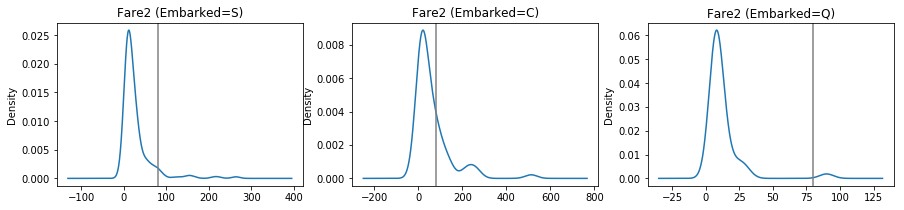

In [76]:
df_tmp = df.dropna(subset=['Embarked'])

embarkeds = df_tmp['Embarked'].unique()

fig, axs = plt.subplots(ncols=len(embarkeds), figsize=(15, 3))

for i, embarked in enumerate(embarkeds):
    
    df_tmp[df_tmp['Embarked'] == embarked]['Fare2'].plot(kind='kde', ax=axs[i])
    axs[i].axvline(x=80, color=base_color2)
    axs[i].set_title('Fare2 (Embarked='+str(embarked)+')')

plt.show()

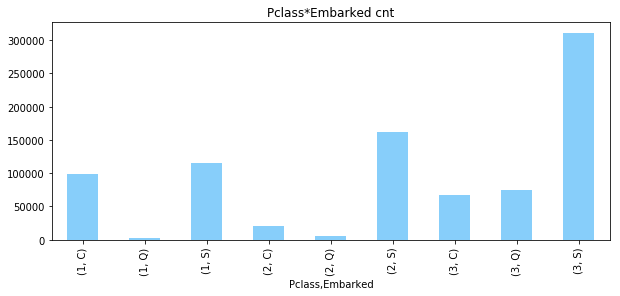

In [88]:
df.groupby(['Pclass', 'Embarked']).sum()['PassengerId'].plot(kind='bar', color=base_color, figsize=(10,4))
plt.title('Pclass*Embarked cnt')
plt.show()

In [94]:
# SかC
# Fareの分布から、Cを代入して、ラベル化する

df['Embarked2'] = df['Embarked'].fillna('C') # 欠損値にCを補填
df['Embarked2_l'] = label_encoder_embarked.fit_transform(df['Embarked2']) # ラベル化

df[df['PassengerId'].isin([60,61,62,63,64,830])][['Embarked', 'Embarked2', 'Embarked2_l']]

,Embarked,Embarked2,Embarked2_l
59,S,S,2
60,C,C,0
61,NaN,C,0
62,S,S,2
63,S,S,2
829,NaN,C,0


In [95]:
# 家族数カラムを作成する

df['Family_cnt'] = df['SibSp']+df['Parch'] # SibSp(兄弟または配偶者)＋Parch（親または子供）
df[['SibSp', 'Parch', 'Family_cnt']].head()

,SibSp,Parch,Family_cnt
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0


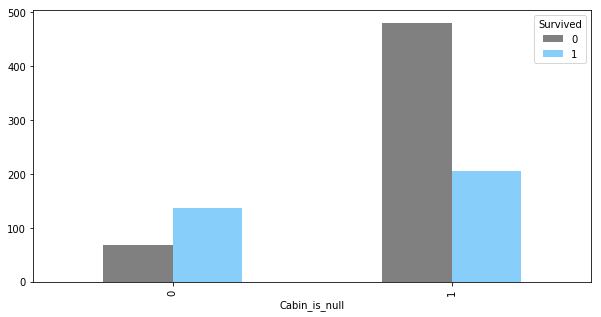

In [96]:
# Cabinの欠損と生存の関係について

df_tmp = df_train.copy()
df_tmp['Cabin_is_null'] = df_tmp['Cabin'].where(df_tmp['Cabin'].isnull(), 0).fillna(1) # Cabinがある場合は0, ない場合は1
df_tmp = df_tmp.groupby(['Cabin_is_null', 'Survived']).size().unstack(['Survived'])
df_tmp.plot(kind='bar', color=[base_color2, base_color], figsize=(10,5))
plt.show()

In [97]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [103]:
# 複合もあるが無視して、頭文字のマーク＋欠損値別でクラス化する

def get_cabin_initial(cabin):
    
    return str(cabin)[0]
    
df['Cabin_initial'] = df['Cabin'].apply(get_cabin_initial)

label_encoder_cabininitial = preprocessing.LabelEncoder()
df['Cabin_initial_l'] = label_encoder_cabininitial.fit_transform(df['Cabin_initial'])
df[['Cabin', 'Cabin_initial_l']].head(10)

,Cabin,Cabin_initial_l
0,NaN,8
1,C85,2
2,NaN,8
3,C123,2
4,NaN,8
5,NaN,8
6,E46,4
7,NaN,8
8,NaN,8
9,NaN,8


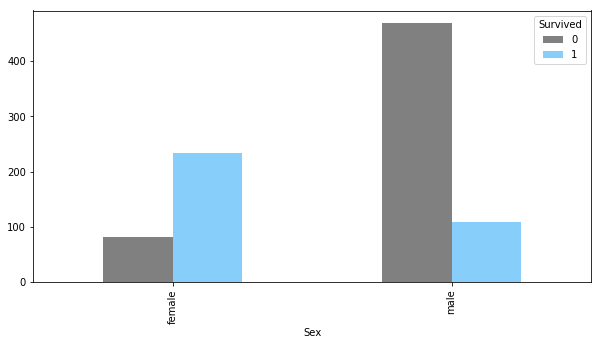

In [104]:
# 性別の生存数

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.groupby(['Sex', 'Survived']).size().unstack(['Survived'])
df_tmp.plot(kind='bar', color=[base_color2, base_color], figsize=(10,5))
plt.show()

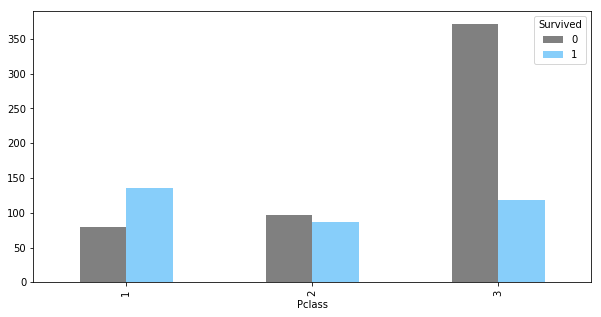

In [105]:
# Pclass別の生存数

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.groupby(['Pclass', 'Survived']).size().unstack(['Survived'])
df_tmp.plot(kind='bar', color=[base_color2, base_color], figsize=(10,5))
plt.show()

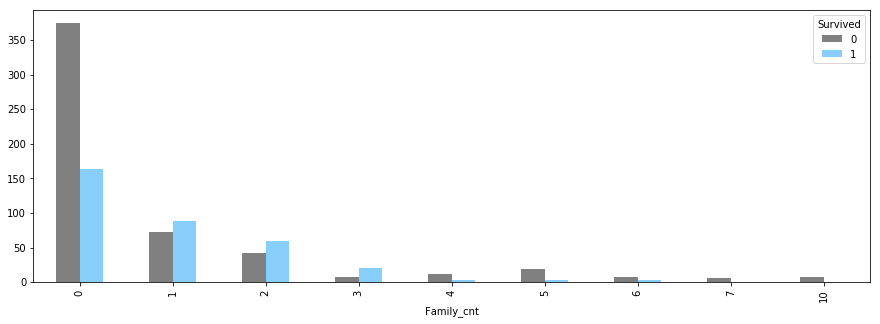

In [106]:
# 家族数別の生存数

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.groupby(['Family_cnt', 'Survived']).size().unstack(['Survived']).fillna(0)
df_tmp.plot(kind='bar', color=[base_color2, base_color], figsize=(15,5))
plt.show()

In [107]:
# 1人は生存率が悪い
# 大家族（5人以上）は生存率が悪い
# 2〜4人の場合は生存率が高い
# それぞれクラス化する

df['Family_cnt_class'] = 0
df.loc[(3 >= df['Family_cnt']) & (df['Family_cnt'] >=1), 'Family_cnt_class'] = 1
df.loc[df['Family_cnt'] >= 4, 'Family_cnt_class'] = 2

df[['Family_cnt', 'Family_cnt_class']].head()

,Family_cnt,Family_cnt_class
0,1,1
1,1,1
2,0,0
3,1,1
4,0,0


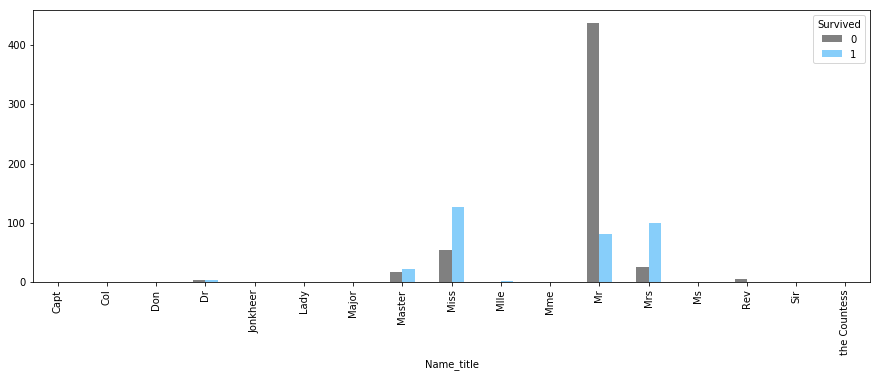

In [108]:
# 敬称別の生存数

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.groupby(['Name_title', 'Survived']).size().unstack(['Survived']).fillna(0)
df_tmp.plot(kind='bar', color=[base_color2, base_color], figsize=(15,5))
plt.show()

In [109]:
# Mrクラス、Missクラス、Mrsクラス、Masterクラス、その他クラスを作成する

df['Name_title_class'] = 0
df.loc[df['Name_title'] == 'Mr', 'Name_title_class'] = 1
df.loc[df['Name_title'] == 'Miss', 'Name_title_class'] = 2
df.loc[df['Name_title'] == 'Mrs', 'Name_title_class'] = 3
df.loc[df['Name_title'] == 'Master', 'Name_title_class'] = 4

df[['Name_title', 'Name_title_l', 'Name_title_class']].head(5)

,Name_title,Name_title_l,Name_title_class
0,Mr,12,1
1,Mrs,13,3
2,Miss,9,2
3,Mrs,13,3
4,Mr,12,1


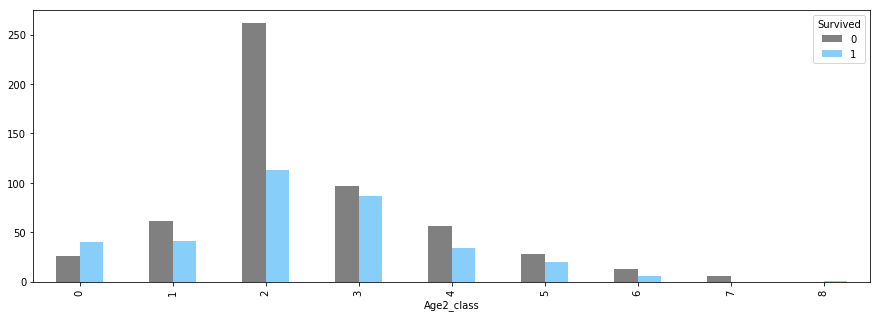

In [110]:
# 年齢階級別の生存数

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.groupby(['Age2_class', 'Survived']).size().unstack(['Survived']).fillna(0)
df_tmp.plot(kind='bar', color=[base_color2, base_color], figsize=(15,5))
plt.show()

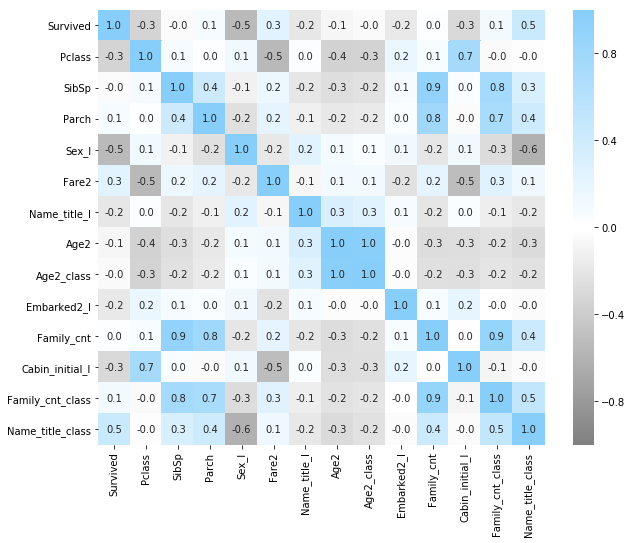

In [111]:
# 生存と他の変数の相関係数の確認

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
df_tmp = df_tmp.dropna(how='any', axis=1) # 欠損値のあるカラムを削除
df_tmp = df_tmp.drop(['PassengerId', 'Fare'], axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(df_tmp.corr(), annot=True, vmax=1, vmin=-1, fmt='.1f', cmap=cm)
plt.show()

In [117]:
# 特徴量を選択する

feature_importance_models = [
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    tree.DecisionTreeClassifier(),
    XGBClassifier()
]
df_compare = pd.DataFrame(columns=['name', 'valid_accuracy_mean', 'rfe_valid_accuracy_mean'])
scoring = ['accuracy']

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')

cols = df_tmp.dropna(how='any', axis=1).select_dtypes(include=['int64', 'float64', 'int32', 'float32', 'uint8']).columns.tolist()
cols.remove('PassengerId')
cols.remove('Survived')
cols.remove('Fare')

df_rfe_cols_cnt = pd.DataFrame(columns=['cnt'], index=cols)
df_rfe_cols_cnt['cnt'] = 0

for i, model in tqdm(enumerate(feature_importance_models), total=len(feature_importance_models)):
    
    name = model.__class__.__name__
    
    rlts = model_selection.cross_validate(model, df_tmp[cols], df_tmp['Survived'], scoring=scoring)
    
    rfe = feature_selection.RFECV(model, step=3)
    rfe.fit(df_tmp[cols], df_tmp['Survived'])
    rfe_cols = df_tmp[cols].columns.values[rfe.get_support()]
    
    rfe_rlts = model_selection.cross_validate(model, df_tmp[rfe_cols], df_tmp['Survived'], scoring=scoring)
    
    df_compare.loc[i, 'name'] = name
    df_compare.loc[i, 'valid_accuracy_mean'] = rlts['test_accuracy'].mean()
    df_compare.loc[i, 'rfe_valid_accuracy_mean'] = rfe_rlts['test_accuracy'].mean()
    
    df_rfe_cols_cnt.loc[rfe_cols, 'cnt'] += 1

100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


In [118]:
cols = df_compare.columns.tolist()
cols.remove('name')
df_compare[cols] = df_compare[cols].astype(np.float64)
df_compare.style.background_gradient(axis=0, cmap=cm)

,name,valid_accuracy_mean,rfe_valid_accuracy_mean
0,AdaBoostClassifier,0.800224,0.806958
1,ExtraTreesClassifier,0.780022,0.804714
2,GradientBoostingClassifier,0.819304,0.815937
3,RandomForestClassifier,0.81257,0.818182
4,DecisionTreeClassifier,0.769921,0.773288
5,XGBClassifier,0.822671,0.821549


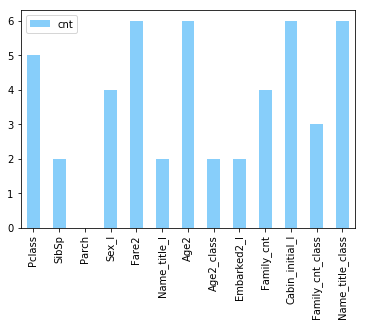

In [119]:
df_rfe_cols_cnt.plot(kind='bar', color=base_color)
plt.show()

In [120]:
# 特徴量を選択して、複数のモデルで精度を調査する

models = [

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    #xgboost
    XGBClassifier()
    
]

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
cols = ['Pclass', 'Sex_l', 'Fare2', 'Age2', 'Family_cnt', 'Cabin_initial_l', 'Name_title_class']

df_compare = pd.DataFrame(columns=['name', 'train_accuracy_mean', 'valid_accuracy_mean', 'time'])
scoring = ['accuracy']

for i, model in tqdm(enumerate(models), total=len(models)):
    
    name = model.__class__.__name__
    
    cv_rlts = model_selection.cross_validate(model, df_tmp[cols], df_tmp['Survived'], scoring=scoring)

    df_compare.loc[i, 'name'] = name
    df_compare.loc[i, 'train_accuracy_mean'] = cv_rlts['train_accuracy'].mean()
    df_compare.loc[i, 'valid_accuracy_mean'] = cv_rlts['test_accuracy'].mean()
    df_compare.loc[i, 'time'] = cv_rlts['fit_time'].mean()
    
cols = df_compare.columns.tolist()
cols.remove('name')
df_compare[cols] = df_compare[cols].astype(np.float64)
df_compare.sort_values(by='valid_accuracy_mean', ascending=False, inplace=True)
df_compare.style.background_gradient(axis=0, cmap=cm)

100%|██████████| 22/22 [00:03<00:00,  6.91it/s]


,name,train_accuracy_mean,valid_accuracy_mean,time
8,RidgeClassifierCV,0.829405,0.826038,0.00334287
19,LinearDiscriminantAnalysis,0.828283,0.824916,0.00232244
21,XGBClassifier,0.890011,0.821549,0.0215081
3,GradientBoostingClassifier,0.916947,0.821549,0.0560783
6,LogisticRegressionCV,0.82716,0.821549,0.240151
1,BaggingClassifier,0.968575,0.813692,0.0135748
18,ExtraTreeClassifier,0.98541,0.809203,0.00167012
0,AdaBoostClassifier,0.849607,0.809203,0.0622528
4,RandomForestClassifier,0.973625,0.805836,0.0103143
2,ExtraTreesClassifier,0.98541,0.801347,0.00942882


In [132]:
# 精度の良いモデルを選んで、投票モデルを学習

vote_models = [

    #Ensemble Methods
    ('abc', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etsc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes
    #('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM
    ('lrcv', linear_model.LogisticRegressionCV()),
    #l('pac', inear_model.PassiveAggressiveClassifier()),
    #('rccv', linear_model.RidgeClassifierCV()), # unable soft voting
    #l('sgdc', inear_model.SGDClassifier()),
    #l('p', inear_model.Perceptron()),
    
    #Navies Bayes
    #('bnb', naive_bayes.BernoulliNB()),
    #('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor
    #('knc', neighbors.KNeighborsClassifier()),
    
    #SVM
    #('svc', svm.SVC(probability=True)),
    #('nsvc', svm.NuSVC(probability=True)),
    #('lsvc', svm.LinearSVC()),
    
    #Trees    
    #('dtc', tree.DecisionTreeClassifier()),
    ('etc', tree.ExtraTreeClassifier()),
    
    #Discriminant Analysis
    ('lda', discriminant_analysis.LinearDiscriminantAnalysis()),
    #('qda', discriminant_analysis.QuadraticDiscriminantAnalysis()),

    #xgboost
    ('xgbc', XGBClassifier())
    
]

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
cols = ['Pclass', 'Sex_l', 'Fare2', 'Age2', 'Family_cnt', 'Cabin_initial_l', 'Name_title_class']

df_compare = pd.DataFrame(columns=['name', 'train_accuracy_mean', 'valid_accuracy_mean', 'time'])
scoring = ['accuracy']

vote_soft_model = ensemble.VotingClassifier(estimators=vote_models , voting='soft')
cv_rlts = model_selection.cross_validate(vote_soft_model, df_tmp[cols], df_tmp['Survived'], scoring=scoring)
df_compare.loc[0, 'name'] = 'soft'
df_compare.loc[0, 'train_accuracy_mean'] = cv_rlts['train_accuracy'].mean()
df_compare.loc[0, 'valid_accuracy_mean'] = cv_rlts['test_accuracy'].mean()
df_compare.loc[0, 'time'] = cv_rlts['fit_time'].mean()

vote_hard_model = ensemble.VotingClassifier(estimators=vote_models, voting='hard')
cv_rlts = model_selection.cross_validate(vote_hard_model, df_tmp[cols], df_tmp['Survived'], scoring=scoring)
df_compare.loc[1, 'name'] = 'hard'
df_compare.loc[1, 'train_accuracy_mean'] = cv_rlts['train_accuracy'].mean()
df_compare.loc[1, 'valid_accuracy_mean'] = cv_rlts['test_accuracy'].mean()
df_compare.loc[1, 'time'] = cv_rlts['fit_time'].mean()

df_compare

,name,train_accuracy_mean,valid_accuracy_mean,time
0,soft,0.955668,0.833895,0.388713
1,hard,0.925926,0.83165,0.378606


In [135]:
# 各モデルのハイパーパラメータをグリッドサーチ

grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
    
    #AdaBoostClassifier
    [{ 
        'n_estimators': grid_n_estimator, #default=50
        'learning_rate': grid_learn, #default=1
        #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
        'random_state': grid_seed
    }],
    
    #BaggingClassifier
    [{
        'n_estimators': grid_n_estimator, #default=10
        'max_samples': grid_ratio, #default=1.0
        'random_state': grid_seed
     }],

    #ExtraTreesClassifier
    [{
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'random_state': grid_seed
     }],

    #GradientBoostingClassifier
    [{
        #'loss': ['deviance', 'exponential'], #default=’deviance’
        'learning_rate': [.05], #default=0.1
        'n_estimators': [300], #default=100
        #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
        'max_depth': grid_max_depth, #default=3   
        'random_state': grid_seed
     }],

    #RandomForestClassifier
    [{
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'oob_score': [True], #default=False
        'random_state': grid_seed
     }],
    
    #LogisticRegressionCV
    [{
        'fit_intercept': grid_bool, #default: True
        #'penalty': ['l1','l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
        'random_state': grid_seed
     }],
    
    # ExtraTreeClassifier
    [{}],
    
    # LinearDiscriminantAnalysis
    [{}],
    
    #XGBClassifier
    [{
        'learning_rate': grid_learn, #default: .3
        'max_depth': [1,2,4,6,8,10], #default 2
        'n_estimators': grid_n_estimator, 
        'seed': grid_seed  
     }]
    
]

df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
cols = ['Pclass', 'Sex_l', 'Fare2', 'Age2', 'Family_cnt', 'Cabin_initial_l', 'Name_title_class']

for model, param in tqdm(zip(vote_models, grid_param), total=len(vote_models)):
    
    best_search = model_selection.GridSearchCV(estimator=model[1], param_grid=param, scoring='roc_auc')
    best_search.fit(df_tmp[cols], df_tmp['Survived'])

    best_param = best_search.best_params_
    model[1].set_params(**best_param)

100%|██████████| 9/9 [01:27<00:00,  9.72s/it]


In [136]:
df_tmp = pd.merge(df_train[['PassengerId', 'Survived']], df, how='inner', on='PassengerId')
cols = ['Pclass', 'Sex_l', 'Fare2', 'Age2', 'Family_cnt', 'Cabin_initial_l', 'Name_title_class']

df_compare = pd.DataFrame(columns=['name', 'train_accuracy_mean', 'valid_accuracy_mean', 'time'])
scoring = ['accuracy']

vote_soft_model = ensemble.VotingClassifier(estimators=vote_models , voting='soft')
cv_rlts = model_selection.cross_validate(vote_soft_model, df_tmp[cols], df_tmp['Survived'], scoring=scoring)
df_compare.loc[0, 'name'] = 'soft'
df_compare.loc[0, 'train_accuracy_mean'] = cv_rlts['train_accuracy'].mean()
df_compare.loc[0, 'valid_accuracy_mean'] = cv_rlts['test_accuracy'].mean()
df_compare.loc[0, 'time'] = cv_rlts['fit_time'].mean()

vote_hard_model = ensemble.VotingClassifier(estimators=vote_models, voting='hard')
cv_rlts = model_selection.cross_validate(vote_hard_model, df_tmp[cols], df_tmp['Survived'], scoring=scoring)
df_compare.loc[1, 'name'] = 'hard'
df_compare.loc[1, 'train_accuracy_mean'] = cv_rlts['train_accuracy'].mean()
df_compare.loc[1, 'valid_accuracy_mean'] = cv_rlts['test_accuracy'].mean()
df_compare.loc[1, 'time'] = cv_rlts['fit_time'].mean()

df_compare

,name,train_accuracy_mean,valid_accuracy_mean,time
0,soft,0.883838,0.835017,0.788434
1,hard,0.851291,0.829405,0.757844


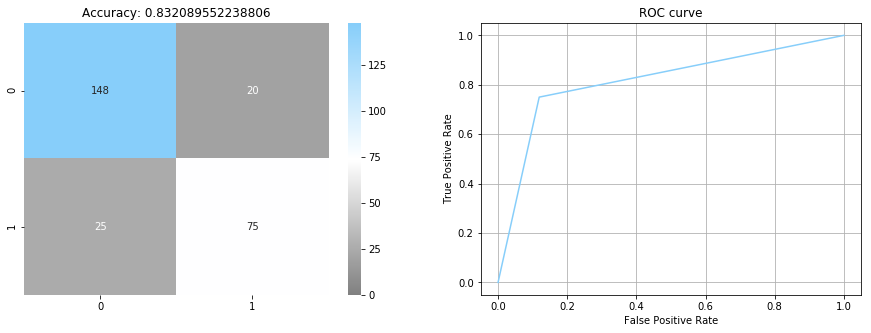

Birer Score: 0.12114809169494158


In [140]:
cols = ['Pclass', 'Sex_l', 'Fare2', 'Age2', 'Family_cnt', 'Cabin_initial_l', 'Name_title_class']
train_x, valid_x, train_y, valid_y = cross_validation.train_test_split(df_tmp[cols], df_tmp['Survived'], test_size=0.3, random_state=0)

vote_soft_model.fit(train_x, train_y)

pred = vote_soft_model.predict(valid_x)

fig, axs = plt.subplots(ncols=2,figsize=(15,5))

sns.heatmap(metrics.confusion_matrix(valid_y, pred), vmin=0, annot=True, fmt='d', cmap=cm, ax=axs[0])
axs[0].set_title('Accuracy: {}'.format(metrics.accuracy_score(valid_y, pred)))
fpr, tpr, thresholds = metrics.roc_curve(valid_y, pred)
axs[1].plot(fpr, tpr, color=base_color)
axs[1].set_title('ROC curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].grid(True)
plt.show()

pred_prob = vote_soft_model.predict_proba(valid_x)
birer_score = metrics.brier_score_loss(valid_y, pred_prob[:,1])
print('Birer Score: {}'.format(birer_score))